In [1]:
import numpy as np
from tqdm import tqdm 
from astropy.io import fits
from matplotlib import pyplot as plt
import aux_functions as a
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from photutils.centroids import centroid_quadratic
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.psf import fit_fwhm
from astropy.table import Table
#%matplotlib ipympl

In [2]:
## FILE READING
archivo = "M41.fits"
info_archivo = fits.info(archivo)
blue = fits.getdata(archivo,ext=0)
red = fits.getdata(archivo,ext=1)
green = fits.getdata(archivo,ext=2)
t_exp = fits.getheader(archivo,ext=0)["EXPTIME"]*5

Filename: M41.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (3096, 2080)   float64   
  1                1 ImageHDU        36   (3096, 2080)   float64   
  2                1 ImageHDU        36   (3096, 2080)   float64   


In [3]:
def get_centroids(img, min_separation=30, n_sigmas=3, show=False, filter_sigma=1.5):
    img_smooth = ndi.gaussian_filter(img, sigma=filter_sigma)
    sigma = img_smooth.std()
    threshold = n_sigmas*sigma
    # Comparison between image_max and image to find the coordinates of local maxima
    coordinates = peak_local_max(img_smooth, min_distance=min_separation,threshold_abs=threshold)
    centroids = np.zeros_like(coordinates, dtype=float)

    for i, (y, x) in tqdm(enumerate(coordinates)):
        xcen, ycen = centroid_quadratic(img_smooth, xpeak=x, ypeak=y)
        centroids[i] = (xcen, ycen)

    # Deleting non-finite values
    centroids = centroids[np.all(np.isfinite(centroids), axis=1)]

    if show:
        plt.figure(figsize=(8,8))
        plt.imshow(img_smooth, cmap=plt.cm.gray, norm="log")
        plt.autoscale(True)
        plt.scatter(centroids[:, 0], centroids[:, 1],linewidths=0.5, edgecolors="red",facecolors='none', s=80,alpha=0.5)
        plt.axis('off')
        plt.title('Estrellas encontradas')
        plt.show()

    return centroids

In [4]:
def get_fluxes(img, centroids, r_aperture=5,r_in_sky=8,r_out_sky=12):
    aperture = CircularAperture(centroids, r=r_aperture)
    annulus = CircularAnnulus(centroids, r_in=r_in_sky, r_out=r_out_sky)
    phot_table = aperture_photometry(img, [aperture, annulus])
    annulus_area = annulus.area
    aperture_area = aperture.area
    sky_mean = phot_table['aperture_sum_1'] / annulus_area
    sky_total = sky_mean * aperture_area
    flux = phot_table['aperture_sum_0'] - sky_total

    return flux

In [5]:
def get_fwhm(flux,img,centroids, star_box_size, num_grid=5,show_top30=False,print_results=False, show_stars=False):
    idx_sorted = np.argsort(flux)[::-1]  # descending
    coordinates_sorted = centroids[idx_sorted] #x,y
    fluxes_sorted = flux[idx_sorted]

    ny, nx = img.shape

    n_grid = num_grid
    y_edges = np.linspace(0, ny, n_grid+1)
    x_edges = np.linspace(0, nx, n_grid+1)

    selected_coords = []
    selected_fluxes = []

    for i in range(n_grid):
        for j in range(n_grid):

            y_min, y_max = y_edges[i], y_edges[i+1]
            x_min, x_max = x_edges[j], x_edges[j+1]

            # stars within the cell
            mask = (
                (coordinates_sorted[:,0] >= x_min) &
                (coordinates_sorted[:,0] <  x_max) &
                (coordinates_sorted[:,1] >= y_min) &
                (coordinates_sorted[:,1] <  y_max)
            )

            if np.any(mask):
                idx = np.where(mask)[0][0]
                selected_coords.append(coordinates_sorted[idx])
                selected_fluxes.append(fluxes_sorted[idx])

    selected_fluxes = np.array(selected_fluxes)
    selected_coords = np.array(selected_coords)

    idx_top30 = np.argsort(selected_fluxes)[::-1][:30]

    coords_final = selected_coords[idx_top30] #x,y

    if show_top30:
        plt.imshow(img, cmap=plt.cm.gray, norm="log")
        plt.autoscale(True)
        plt.scatter(coords_final[:, 0], coords_final[:, 1],linewidths=1.5, edgecolors="yellow",facecolors='none', s=80)
        plt.axis('off')
        plt.title('Top 30 positions')
        plt.show()

    fwhm_values = []
    box_size = star_box_size
    for x0,y0 in tqdm(coords_final):
        half = box_size // 2
        y0 = int(y0)
        x0 = int(x0)

        stamp = img[
            y0-half:y0+half+1,
            x0-half:x0+half+1
        ]
        stamp = stamp - np.median(stamp)

        if show_stars:
            plt.imshow(stamp, cmap=plt.cm.gray, norm="log")
            plt.show()

        # avoid bordering issues
        if stamp.shape != (box_size, box_size):
            continue

        fwhm = fit_fwhm(stamp)
        fwhm_values.append(fwhm)

    fwhm_array = np.array(fwhm_values)
    if print_results:
        print("FWHM medio:", np.mean(fwhm_array))
        print("Desviación:", np.std(fwhm_array))
        print("Porcentaje:", np.std(fwhm_array)/np.mean(fwhm_array))
    
    FWHM = np.mean(fwhm_array)

    return FWHM

In [6]:
def mag_inst(flux, t=t_exp):
    return -2.5*np.log10(flux/t) 


Radio de apertura: 2.5 - 4 FWHM | 2-3 FWHM

Radio interno del anillo de cielo: 3.5 - 4 FWHM

Radio externo del anillo de cielo: 5-6 FWHM

285it [00:06, 41.43it/s]


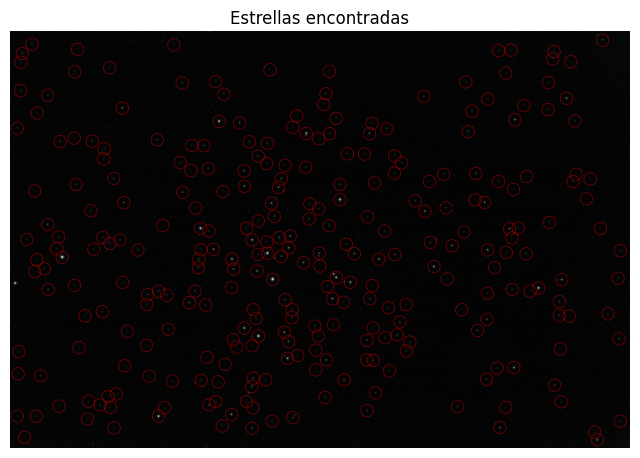

In [7]:
red_centroids = get_centroids(red,show=True,n_sigmas=2.5)
red_fluxes_test = get_fluxes(red, red_centroids)

In [8]:
red_fwhm = get_fwhm(red_fluxes_test,red,red_centroids,star_box_size=19,show_top30=False,print_results=True,show_stars=False)

100%|██████████| 25/25 [00:01<00:00, 23.24it/s]

FWHM medio: 2.9647809967119696
Desviación: 0.13926995306757212
Porcentaje: 0.04697478607088572


In [9]:
red_aperture = 2.5*red_fwhm
red_in_sky = 3.5*red_fwhm
red_out_sky = 5.5*red_fwhm

red_fluxes = get_fluxes(red,red_centroids,r_aperture=red_aperture, r_in_sky=red_in_sky, r_out_sky=red_out_sky)
red_inst_mag = mag_inst(red_fluxes)

#a.show_magnitudes(red,red_inst_mag,red_centroids)

281it [00:05, 47.53it/s]


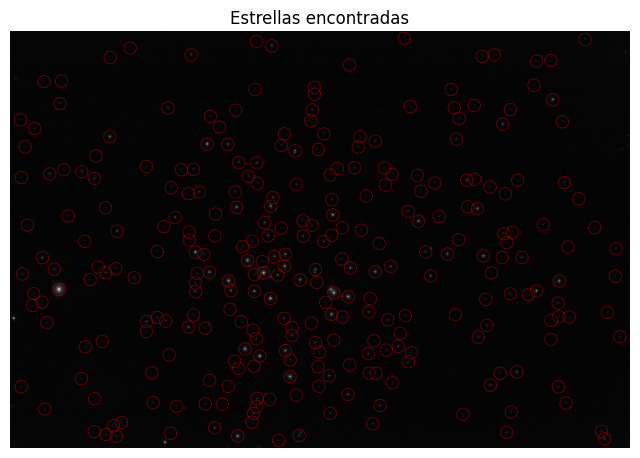

In [10]:
blue_centroids = get_centroids(blue,show=True,n_sigmas=2.0)
blue_fluxes_test = get_fluxes(blue, blue_centroids)

In [11]:
blue_fwhm = get_fwhm(blue_fluxes_test,blue,blue_centroids,star_box_size=19,show_top30=False,print_results=True,show_stars=False)
blue_aperture = 2.5*blue_fwhm
blue_in_sky = 3.5*blue_fwhm
blue_out_sky = 5.5*blue_fwhm
blue_fluxes = get_fluxes(blue,blue_centroids,r_aperture=blue_aperture, r_in_sky=blue_in_sky, r_out_sky=blue_out_sky)
blue_inst_mag = mag_inst(blue_fluxes)

100%|██████████| 25/25 [00:01<00:00, 22.94it/s]


FWHM medio: 3.393212847081904
Desviación: 0.40401181505271444
Porcentaje: 0.11906468390279633


280it [00:05, 47.41it/s]


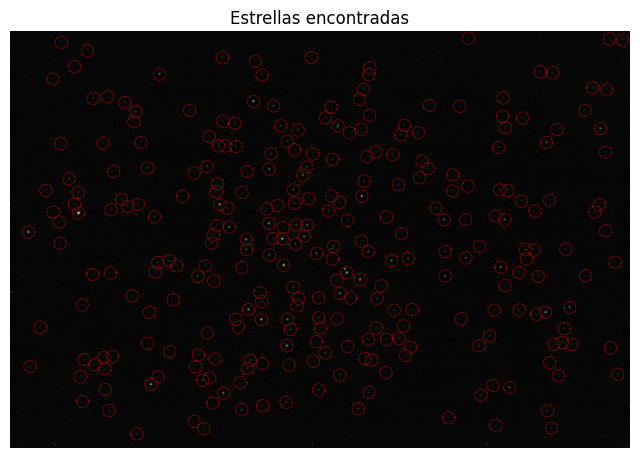

In [12]:
green_centroids = get_centroids(green,show=True,n_sigmas=2.9)
green_fluxes_test = get_fluxes(green, green_centroids)

In [13]:
green_fwhm = get_fwhm(green_fluxes_test,green,green_centroids,star_box_size=19,show_top30=False,print_results=True,show_stars=False)
green_aperture = 2.5*green_fwhm
green_in_sky = 3.5*green_fwhm
green_out_sky = 5.5*green_fwhm
green_fluxes = get_fluxes(green,green_centroids,r_aperture=green_aperture, r_in_sky=green_in_sky, r_out_sky=green_out_sky)
green_inst_mag = mag_inst(green_fluxes)

100%|██████████| 25/25 [00:01<00:00, 22.17it/s]


FWHM medio: 2.9290547249053276
Desviación: 0.6040608036674251
Porcentaje: 0.20623063083498702


In [14]:
#Exportar tablas
blue_table = Table()

blue_table['x'] = blue_centroids[:,0]
blue_table['y'] = blue_centroids[:,1]
blue_table['mag_blue'] = blue_inst_mag
blue_table.write('blue_table.vot', format='votable', overwrite=True)

red_table = Table()

red_table['x'] = red_centroids[:,0]
red_table['y'] = red_centroids[:,1]
red_table['mag_red'] = red_inst_mag
red_table.write('red_table.vot', format='votable', overwrite=True)

green_table = Table()

green_table['x'] = green_centroids[:,0]
green_table['y'] = green_centroids[:,1]
green_table['mag_green'] = green_inst_mag
green_table.write('green_table.vot', format='votable', overwrite=True)

In [15]:
red_calib_positions = np.array([(1698.1,1251.6),(1628.4,1227.2),(1585.4,1272.5),(1611.0,1335.2),(1663.3,1350.3)])
blue_calib_positions = np.array([(1688.6,1324.2),(1616.74,1304.83),(1575.8,1352.2),(1604.3,1412.2),(1660.1,1424.7)])
green_calib_positions = np.array([(1747.9,1237.8),
                                  (1681.1,1204.4),
                                  (1631.5,1242.5),
                                  (1647.4,1307.3),
                                  (1699.0,1330.8)])

In [16]:
def match_to_centroids(approx_positions_xy, centroids_xy):
    """
    approx_positions_xy : array Nx2 (x,y)
    centroids_yx        : array Mx2 (y,x)

    Devuelve array Nx2 con centroides reales en formato (x,y)
    """

    matched_positions = []

    for x_approx, y_approx in approx_positions_xy:

        # distancia euclidiana
        distances = np.sqrt(
            (centroids_xy[:,0] - x_approx)**2 +
            (centroids_xy[:,1] - y_approx)**2
        )

        idx = np.argmin(distances)
        matched_positions.append(centroids_xy[idx])

    return np.array(matched_positions)

In [17]:
red_real   = match_to_centroids(red_calib_positions, red_centroids)
blue_real  = match_to_centroids(blue_calib_positions, blue_centroids)
green_real = match_to_centroids(green_calib_positions, green_centroids)

In [18]:
print(np.sqrt(np.sum((red_real - red_calib_positions)**2, axis=1)))

[1.17431869 1.11436926 0.93709301 0.98308994 1.76241445]


In [19]:
def rigid_transform_2D(source, target):
    """
    source : Nx2 (x,y)
    target : Nx2 (x,y)

    Devuelve:
        R (2x2)
        t (2,)
    """

    # Centroides
    centroid_source = np.mean(source, axis=0)
    centroid_target = np.mean(target, axis=0)

    # Centrar
    S = source - centroid_source
    T = target - centroid_target

    # Matriz de covarianza
    H = S.T @ T

    # SVD
    U, _, Vt = np.linalg.svd(H)

    R = Vt.T @ U.T

    # Corregir reflexión si aparece
    if np.linalg.det(R) < 0:
        Vt[1,:] *= -1
        R = Vt.T @ U.T

    # Traslación
    t = centroid_target - R @ centroid_source

    return R, t

In [20]:
R_blue, t_blue = rigid_transform_2D(blue_real, red_real)
R_green, t_green = rigid_transform_2D(green_real, red_real)

In [21]:
theta_blue = np.arctan2(R_blue[1,0], R_blue[0,0])
theta_green = np.arctan2(R_green[1,0], R_green[0,0])

print("Blue rotation (deg):", np.degrees(theta_blue))
print("Green rotation (deg):", np.degrees(theta_green))

Blue rotation (deg): 3.4806313766859094
Green rotation (deg): -8.294525569556175


In [22]:
blue_aligned = (R_blue @ blue_centroids.T).T + t_blue
green_aligned = (R_green @ green_centroids.T).T + t_green

In [23]:
blue_test = (R_blue @ blue_real.T).T + t_blue
green_test = (R_green @ green_real.T).T + t_green

print("Blue residuals:")
print(blue_test - red_real)

print("\nGreen residuals:")
print(green_test - red_real)

Blue residuals:
[[ 0.10721493 -0.05257415]
 [-0.05117094  0.05162654]
 [-0.02469392 -0.03000514]
 [ 0.03393128  0.03116852]
 [-0.06528135 -0.00021577]]

Green residuals:
[[ 0.13375934 -0.04630086]
 [ 0.02858444 -0.00071912]
 [-0.063777    0.14409878]
 [ 0.07431057 -0.00086813]
 [-0.17287735 -0.09621067]]


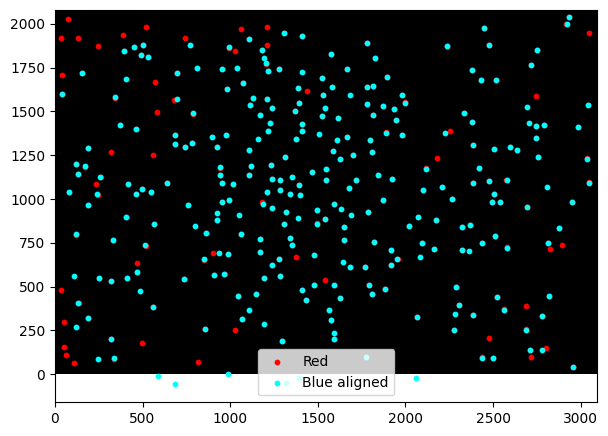

In [24]:
plt.figure(figsize=(7,7))
plt.imshow(red, origin='lower', cmap='gray')

plt.scatter(red_centroids[:,0], red_centroids[:,1],
            s=10, c='red', label='Red')

plt.scatter(blue_aligned[:,0], blue_aligned[:,1],
            s=10, c='cyan', label='Blue aligned')

plt.legend()
plt.show()

In [25]:
from scipy.spatial import cKDTree

def match_catalog(ref_coords, other_coords, radius):
    """
    ref_coords   : Nx2 (x,y)  → catálogo referencia (red)
    other_coords : Mx2 (x,y)  → catálogo alineado
    radius       : radio máximo en pix

    Devuelve:
        indices_ref
        indices_other
    """

    tree = cKDTree(other_coords)
    distances, indices = tree.query(ref_coords, distance_upper_bound=radius)

    valid = distances != np.inf

    return np.where(valid)[0], indices[valid]

In [26]:
idx_red_B, idx_blue = match_catalog(
    red_centroids,
    blue_aligned,
    radius=2
)
idx_red_G, idx_green = match_catalog(
    red_centroids,
    green_aligned,
    radius=2
)

common_red = np.intersect1d(idx_red_B, idx_red_G)

# Para blue
mask_B = np.isin(idx_red_B, common_red)
blue_idx_final = idx_blue[mask_B]

# Para green
mask_G = np.isin(idx_red_G, common_red)
green_idx_final = idx_green[mask_G]

# Red
red_idx_final = common_red

final_table = Table()

final_table['x'] = red_centroids[red_idx_final][:,0]
final_table['y'] = red_centroids[red_idx_final][:,1]

final_table['B'] = blue_inst_mag[blue_idx_final]
final_table['R'] = red_inst_mag[red_idx_final]
final_table['G'] = green_inst_mag[green_idx_final]

In [27]:
color_BR = final_table['B'] - final_table['R']
color_GR = final_table['G'] - final_table['R']
color_BG =final_table['B'] - final_table['G']

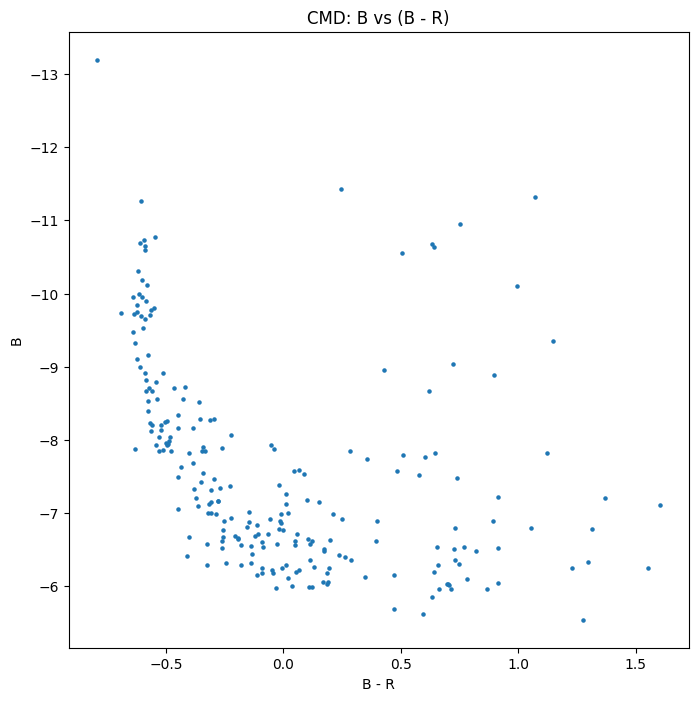

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(color_BR, final_table['B'], s=5)

plt.gca().invert_yaxis()

plt.xlabel("B - R")
plt.ylabel("B")
plt.title("CMD: B vs (B - R)")
plt.show()

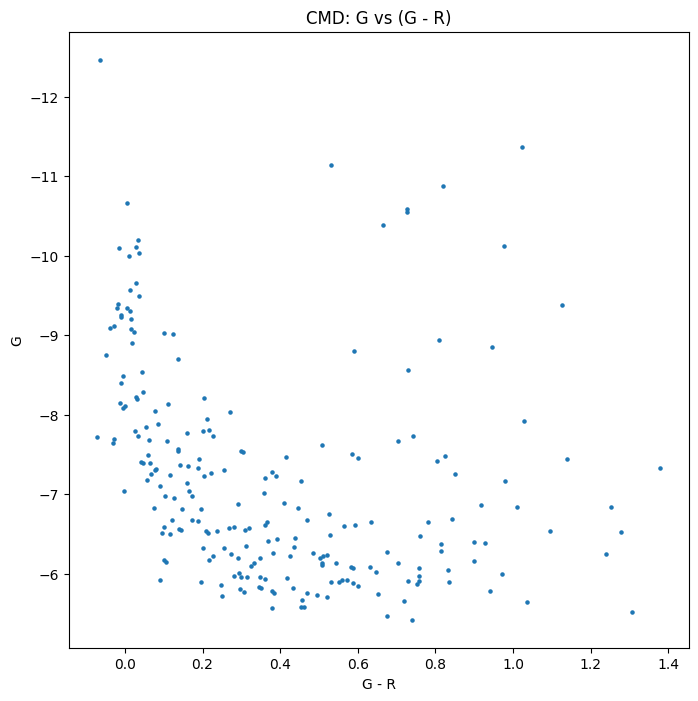

In [29]:
plt.figure(figsize=(8,8))
plt.scatter(color_GR, final_table['G'], s=5)

plt.gca().invert_yaxis()

plt.xlabel("G - R")
plt.ylabel("G")
plt.title("CMD: G vs (G - R)")
plt.show()

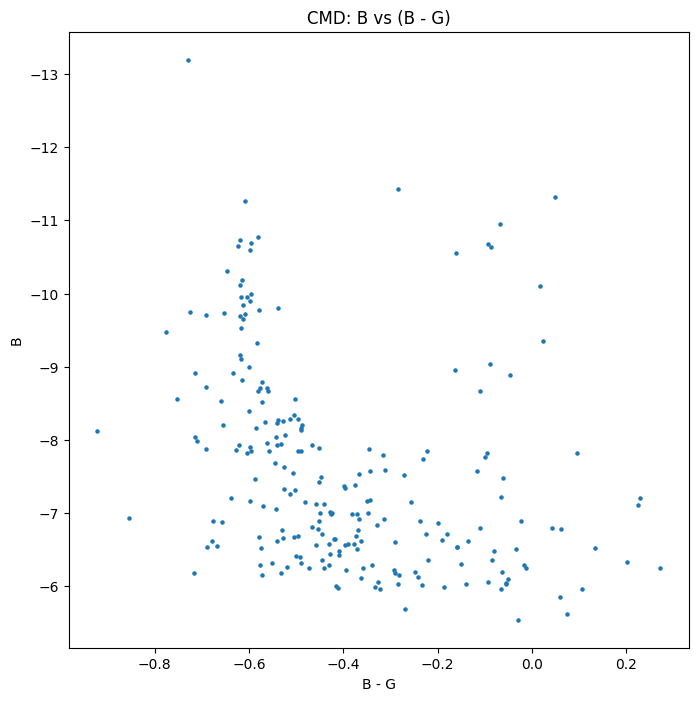

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(color_BG, final_table['B'], s=5)

plt.gca().invert_yaxis()

plt.xlabel("B - G")
plt.ylabel("B")
plt.title("CMD: B vs (B - G)")
plt.show()